# Topic Modeling Practice

The original link was [the Coding Interface](https://thecodinginterface.com/blog/nlp-topic-modeling/)


In [120]:
import nltk
nltk.download( ['wordnet', 'stopwords', 'punkt' ] )

[nltk_data] Downloading package wordnet to /Volumes/GDRIVE_SSD/homes/a
[nltk_data]     lex/datascience/620_WEB_ANALYTICS_2022_SPRING/nltk_dat
[nltk_data]     a...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Volumes/GDRIVE_SSD/homes
[nltk_data]     /alex/datascience/620_WEB_ANALYTICS_2022_SPRING/nltk_d
[nltk_data]     ata...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Volumes/GDRIVE_SSD/homes/ale
[nltk_data]     x/datascience/620_WEB_ANALYTICS_2022_SPRING/nltk_data.
[nltk_data]     ..
[nltk_data]   Package punkt is already up-to-date!


True

## Assembling a Bag-Of-Words Representation of Text for Topic Modeling

In order to perform text analytics one must have a corpus (aka collection of documents) of text to work with. For this article I'm going to use a dozen or so blog posts from thecodinginterface.com to demonstrate topic modeling with.

An easy and practical way to get my hands on some these blog posts is to use the requests library to issue GET HTTP fetches then parse the text from the returned static content with the trusty ole BeautifulSoup library.

In [121]:
import requests

from bs4 import BeautifulSoup

spamham_url = "https://thecodinginterface.com/blog/spam-ham-ml-scikit-learn/"
response = requests.get(spamham_url)

soup = BeautifulSoup(response.content)
# select the main content div containing the article text
article = soup.find('div', class_='card-body-big')

full_text = article.get_text()

print(full_text[:725])


Intro to Machine Learning with Spammy Emails, Python and, SciKit Learn

 
            By Adam McQuistan
            in
            
            
            Machine Learning 
            
            
             03/19/2021

 Comment



Introduction
Machine Learning is capturing significant attention among technologists and innovators due to a desire to shift from descriptive analytics focused on understanding what happened in the past towards predicting what is likely to occur in the future as well as prescribe actions to take in response to that prediction. In this article I focus on the use case of classifying email messages as either spam or ham with supervised machine learning using Python and SciKit Learn.




In the above code I fetch the Spam / Ham blog post, parse the article down to the raw text content and preview the first 725 characters.  I will use this preview of text to demonstrate various tokenization techniques available through the NLTK library as well as assemble a bag-of-words representation of the text using the Dictionary class from the GENSIM library.

First I use the word_tokenizer to tokenize the preview text content into individual words. I then further process these words to a consistent lowercase format, remove any non-alphabetic tokens (aka terms), lemmatize the terms into word roots, and remove stop words.

In [122]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# common stop words in the English language
en_stopwords = stopwords.words('english')

# common stop words I expect to see in articles in thecodinginterface.com
tci_stopwords = ['class', 'adam', 'mcquistan', 'adammcquistan']

# stop words collection as a fast searchable set
article_stopwords = set(en_stopwords + tci_stopwords)

# instantiate the Lemmatizer to perform stemming/lemmatization
lmr = WordNetLemmatizer()

# tokenize the text
article_doc = []
for t in word_tokenize(full_text):
    if t.isalpha():
        t = lmr.lemmatize(t.lower())
        if t not in article_stopwords:
            article_doc.append(t)

print(article_doc[:10])

['intro', 'machine', 'learning', 'spammy', 'email', 'python', 'scikit', 'learn', 'machine', 'learning']


In [123]:
a = word_tokenize(full_text)
print(a[:20])

['Intro', 'to', 'Machine', 'Learning', 'with', 'Spammy', 'Emails', ',', 'Python', 'and', ',', 'SciKit', 'Learn', 'By', 'Adam', 'McQuistan', 'in', 'Machine', 'Learning', '03/19/2021']


In [124]:
# build a dictionary consisting of the tokenized document's text mapping tokens to ids
from gensim.corpora.dictionary import Dictionary

doc_dict = Dictionary([article_doc])

In [125]:
list(doc_dict.items())[:10]

[(0, 'ability'),
 (1, 'able'),
 (2, 'account'),
 (3, 'accuracy'),
 (4, 'accurate'),
 (5, 'accurracy'),
 (6, 'across'),
 (7, 'action'),
 (8, 'activity'),
 (9, 'actual')]

The GENSIM Dictionary is an efficient lookup data structure that is useful for topic modeling. For example it has a token2id field that is a Python dict which maps each token within the vocabulary to its unique ID.


In [126]:
# print first 10 tokens in vocabulary
for token, token_id in list(doc_dict.token2id.items())[:10]:
    print('{} => {}'.format(token, token_id))

ability => 0
able => 1
account => 2
accuracy => 3
accurate => 4
accurracy => 5
across => 6
action => 7
activity => 8
actual => 9


The instantiated Dictionary object can also be used like a regular Python dict to lookup tokens by ID like so.

In [127]:
# lookup the term with the term ID of 0 (the first)
print( doc_dict[0], " ", doc_dict[8] )

ability   activity


There are also many other useful methods on the Dictionary class which allow you to do things like calculate the bag of words for a given tokenized document based of the vocabulary of the instantiated Dictionary data structure. Calling the doc2bow(doc) method returns a bag-of-words representation as a list of two item tuples where each tuple is composed of the ID of a token and the frequency to which that token existed.

In [128]:
article_bow = doc_dict.doc2bow( article_doc )

# print the first 10 vocabulary tokens and their frequency within the article
for token_id, token_cnt in article_bow[:10]:
    print("{} = {}  token_id: {}".format(doc_dict[token_id], token_cnt, token_id ) )


ability = 2  token_id: 0
able = 4  token_id: 1
account = 1  token_id: 2
accuracy = 5  token_id: 3
accurate = 1  token_id: 4
accurracy = 1  token_id: 5
across = 2  token_id: 6
action = 1  token_id: 7
activity = 1  token_id: 8
actual = 1  token_id: 9


Part of the reason for creating a bag-of-word representation of a body of text of use doing topic modeling is so you can see which words or tokens occur the most frequently. After all, it seems logical that words that occur often hold a propensity to be meaningful. Thus it is a good idea to create a visual or two of the most frequently occuring words. Two common visuals for simple topic modeling and identification are bar plots and word clouds.

To begin I'll show a simple bar chart using the popular matplotlib graphing library.



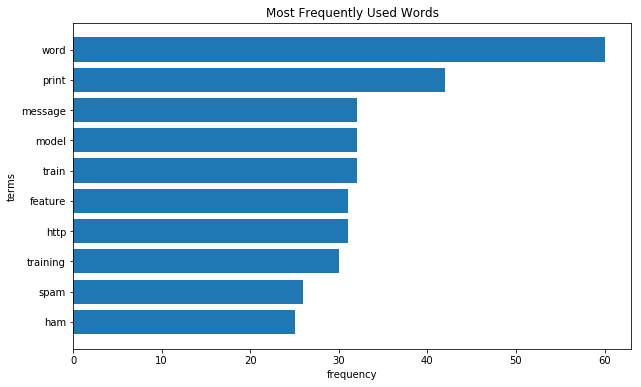

In [129]:
%matplotlib inline
import matplotlib.pyplot as plt

most_frequent = sorted( article_bow, key = lambda x: x[1], reverse = True)

term_ids, counts = zip(*most_frequent)

top_terms = [doc_dict[id] for id in term_ids[:10] ]
top_term_counts = counts[:10]

fig, ax = plt.subplots( figsize = (10, 6 ))
plt.barh( top_terms, top_term_counts )
plt.gca().invert_yaxis()
ax.set_xlabel('frequency')
ax.set_ylabel('terms')
ax.set_title('Most Frequently Used Words')
plt.show()


As for the Word Cloud representation there is a nice package named word_cloud that helps ease the pain of generating these nifty little images. Word clouds are similar to bar charts in they depict the varying frequencies of a collection of words in a document where the more prevalent words are often biggest and boldest in the graphic.

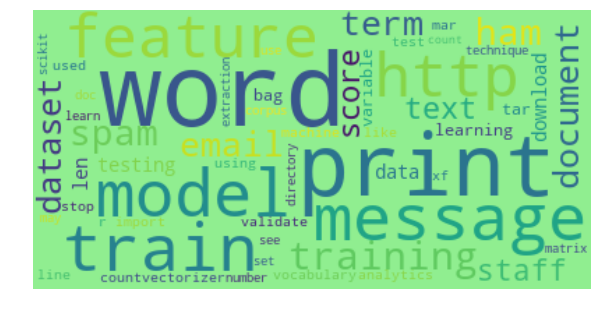

In [130]:
%matplotlib inline
from wordcloud import WordCloud

most_frequent = sorted( article_bow, key = lambda x: x[1], reverse = True )
frequencies = { doc_dict[id] : cnt for id, cnt in most_frequent      }

wordcloud = WordCloud( background_color = "lightgreen" , min_font_size = 8).fit_words(frequencies)

fig, ax = plt.subplots( figsize = (10, 10 ))
plt.imshow( wordcloud, interpolation = "bilinear" )
plt.axis("off")
plt.show()

## Topic Modeling with Latent Dirichlet Allocation (LDA)

Thus far I've used fairly naive methods for topic identification and topic modeling leaning on simple word frequencies and graphical analysis to surmise potentially meaningful terms. In this section I ramp up the quantitative rigour a bit with the use of an unsupervised machine learning decomposition technique known as Latent Dirichlet Allocation (LDA). LDA assembles models of groups of words that appear together representing one or more topics but, these topics are often semantically different from the common notion of topics. Instead they are more aligned with technical machine learning notions such as feature engineering originating from dimensionality reduction ("Latent Dirichlet Allocation", Wikipedia). What this means is sometimes LDA will identify a collection of terms associated with a particular document that are not expected but, these terms are often important in search retrieval and classification of the document or a set of documents with alternative relationships. For example, some terms might be deemed significant for LDA across a number of documents seemingly of different categories but, if the same author wrote them its likely indicative of a writing style the author employs which could be useful in document retrieval when searching for articles by that specific author.

In demonstrating the LDA method I'm going to broaden my text data (aka corpus) under study to around a dozen articles across a variety of technologies I've written about and published on thecodinginterface.com then use LDA to identify topics across the corpus as well as specific to each article. To start I'll build a couple of reusable functions which will be useful for fetching, parsing, tokenizing and, representing each document as a bag-of-words.

In [131]:
from typing import Optional

def fetch_article(url: str) -> str:
    response = requests.get(url)
    
    soup = BeautifulSoup( response.content )
    
    # select the main content div containing the article text
    article = soup.find('div',  class_ = 'card-body-big' )
    
    full_text = article.get_text()
    
    return full_text



def tokenize_article(article : str, extra_stops ):

    # common stop words in the English language
    
    en_stopwords = stopwords.words('english')
    
    if extra_stops:
        en_stopwords += extra_stops
    
    # stop words collection as a fast searchable set
    article_stopwords = set(en_stopwords )
    
    lmr = WordNetLemmatizer()
    
    # tokenize the text
    article_tokens = []
    
    for t in word_tokenize(article):
        if t.isalpha():
            t = lmr.lemmatize(t.lower())
            if t not in article_stopwords:
                article_tokens.append(t)
                
    return article_tokens
    

Now I'll use the fetch_article and tokenize_article functions to fetch and tokenize a series of article URLs then assemble a GENSIM Dictionary as well as a corpus of documents each being represented in the bag-of-words format.   We add debugging and delay the requests by $K = 5$ seconds between each document otherwise the web server disconnects the session. 

In [132]:
import time

urls = [
    'https://thecodinginterface.com/blog/spam-ham-ml-scikit-learn/',
    'https://thecodinginterface.com/blog/opencv-Mat-from-array-and-vector/',
    'https://thecodinginterface.com/blog/sql-window-functions/',
    'https://thecodinginterface.com/blog/bridging-nodejs-and-python-with-pynode/',
    'https://thecodinginterface.com/blog/django-auth-part1/',
    'https://thecodinginterface.com/blog/django-auth-part4/',
    'https://thecodinginterface.com/blog/intro-to-java-for-devs/',
    'https://thecodinginterface.com/blog/text-analytics-app-with-flask-and-textblob/',
    'https://thecodinginterface.com/blog/aws-s3-python-boto3/',
    'https://thecodinginterface.com/blog/intro-to-pyspark/',
    'https://thecodinginterface.com/blog/java-web-scraping-app-with-jsoup-and-javafx/',
    'https://thecodinginterface.com/blog/javafx-alerts-and-dialogs/',
    'https://thecodinginterface.com/blog/intro-to-pyflink/',
    'https://thecodinginterface.com/blog/opencv-cpp-vscode/'
]

docs = []
for url in urls:
    print("Begin fetching ... " + url )
    article_txt = fetch_article(url)
    time.sleep(5) # server nap
    article_tokens = tokenize_article(article_txt, extra_stops=['print', 'date', 'div', 'adam', 'mcquistan'])
    print("Tokenized article "  + url )
    docs.append(article_tokens)

print("Done..\n")
    

Begin fetching ... https://thecodinginterface.com/blog/spam-ham-ml-scikit-learn/
Tokenized article https://thecodinginterface.com/blog/spam-ham-ml-scikit-learn/
Begin fetching ... https://thecodinginterface.com/blog/opencv-Mat-from-array-and-vector/
Tokenized article https://thecodinginterface.com/blog/opencv-Mat-from-array-and-vector/
Begin fetching ... https://thecodinginterface.com/blog/sql-window-functions/
Tokenized article https://thecodinginterface.com/blog/sql-window-functions/
Begin fetching ... https://thecodinginterface.com/blog/bridging-nodejs-and-python-with-pynode/
Tokenized article https://thecodinginterface.com/blog/bridging-nodejs-and-python-with-pynode/
Begin fetching ... https://thecodinginterface.com/blog/django-auth-part1/
Tokenized article https://thecodinginterface.com/blog/django-auth-part1/
Begin fetching ... https://thecodinginterface.com/blog/django-auth-part4/
Tokenized article https://thecodinginterface.com/blog/django-auth-part4/
Begin fetching ... https:/

In [133]:
corpus_dict = Dictionary(docs)

Let's print out the first $N$ elements of the corpus.

In [134]:
print(list(corpus_dict.items())[:10] )

[(0, 'ability'), (1, 'able'), (2, 'account'), (3, 'accuracy'), (4, 'accurate'), (5, 'accurracy'), (6, 'across'), (7, 'action'), (8, 'activity'), (9, 'actual')]


### Filtering out extreme values

The GENSIM Dictionary object gives a useful method named filter_extremes(...) which can be used to remove tokens that are outliers in that they either occur too frequently or too often across the collection of documents in a corpus. I'll use it to remove all terms that occur in more than 50% of the articles.  Note that the API for `filter_extremes` using `no_below` with absolute numbers and `no_above` with fraction of total corpus size.

In [135]:
print("Count of terms before filtering {}".format(len(corpus_dict)))

Count of terms before filtering 3219


In [136]:
corpus_dict.filter_extremes(no_below=1, no_above=0.5)

print("Count of terms after filtering {}".format(len(corpus_dict)))

Count of terms after filtering 3043


In [137]:
test_corpus_dict = Dictionary(docs)
print("Count of terms before filtering {}".format(len(test_corpus_dict)) )

test_corpus_dict.filter_extremes(no_above = 0.5)

print("Count of terms after filtering {}".format(len(test_corpus_dict)) )

print(list(test_corpus_dict.items())[:10])


Count of terms before filtering 3219
Count of terms after filtering 229
[(0, 'ability'), (1, 'actually'), (2, 'addition'), (3, 'additional'), (4, 'already'), (5, 'analysis'), (6, 'appear'), (7, 'array'), (8, 'ask'), (9, 'bar')]


In [138]:
corpus = [corpus_dict.doc2bow(doc) for doc in docs]

At this point I have a corpus of text as a collection of documents each in bag-of-words format. I can now use this processed text to build an inference model based off LDA to perform topic modeling.

In [139]:
from gensim.models.ldamodel import LdaModel

n_topics = 16

# train an unsupervised model of k topics
lda = LdaModel(corpus, num_topics=n_topics, random_state=23, id2word=corpus_dict)

I can now query the trained LDA model to get an idea of the probability of each term in the vocabulary belonging to each of the 12 specified topics derived during model training. I can call the get_topics() method of the trained LDA model which returns a numpy array representing a matrix of 12 rows (one for each topic) and a column (aka feature) for each term in the vocabulary where each intersection of topic and feature is the probability of that term belonging to the given row's topic. Below I've then converted that numpy 2d array into a Pandas dataframe and printed out all topics and every 400th feature column.



In [140]:
import pandas as pd

topics_mat = lda.get_topics()
ids, cols = zip(*lda.id2word.items())

df = pd.DataFrame(topics_mat, columns=cols)

df.iloc[:, ::400]

,ability,msg,ii,material,web,originally,binarytype,textfield
0,0.001080,0.000428,0.000333,0.000136,0.001424,0.000082,0.000101,0.000205
1,0.000418,0.000646,0.000222,0.000103,0.000867,0.000203,0.000133,0.000438
2,0.000702,0.000937,0.000168,0.000127,0.001803,0.000107,0.000054,0.000741
3,0.000785,0.000775,0.000115,0.000097,0.002793,0.000175,0.000077,0.000787
4,0.000656,0.000716,0.000239,0.000090,0.001858,0.000125,0.000132,0.000661
5,0.001435,0.000599,0.000596,0.000073,0.001850,0.000099,0.000077,0.000583
6,0.000493,0.000834,0.000334,0.000082,0.003735,0.000085,0.000072,0.001408
7,0.000742,0.001013,0.000192,0.000135,0.001740,0.000115,0.000203,0.000435
8,0.000702,0.000416,0.000683,0.000110,0.000919,0.000094,0.000106,0.000576
9,0.000929,0.000559,0.000364,0.000104,0.001761,0.000143,0.000113,0.000919


I can then use the show_topics(...) method of the GENSIM LDA model to fetch each of the 12 derived topics along with a number of word with the highest probability of representing that topic.

In [141]:
topics = lda.show_topics(num_topics=n_topics, num_words=5, formatted=False)
topics = sorted(topics, key=lambda x: int(x[0]))
print("Num topics {}".format(len(topics)))
topics

Num topics 16


[(0,
  [('include', 0.010899797),
   ('survey', 0.010646723),
   ('view', 0.009492954),
   ('django', 0.00910874),
   ('mat', 0.008829032)]),
 (1,
  [('movie', 0.0129707),
   ('java', 0.01162887),
   ('interface', 0.010577292),
   ('public', 0.009922874),
   ('int', 0.008504087)]),
 (2,
  [('word', 0.008196627),
   ('table', 0.0076001794),
   ('public', 0.0059381896),
   ('java', 0.0059271823),
   ('interface', 0.005612172)]),
 (3,
  [('java', 0.013157272),
   ('movie', 0.008974899),
   ('public', 0.0083204545),
   ('url', 0.007786811),
   ('interface', 0.0071402118)]),
 (4,
  [('row', 0.013775929),
   ('java', 0.0075606424),
   ('word', 0.0060984176),
   ('spark', 0.0059809526),
   ('text', 0.0055927304)]),
 (5,
  [('row', 0.03334604),
   ('amount', 0.01629411),
   ('month', 0.014226469),
   ('expression', 0.0061474266),
   ('id', 0.0058407406)]),
 (6,
  [('table', 0.008108448),
   ('url', 0.007667424),
   ('java', 0.007533053),
   ('django', 0.0066678273),
   ('dialog', 0.0055992915)

Some may find it useful to plot these topics and their associated word probabilities.

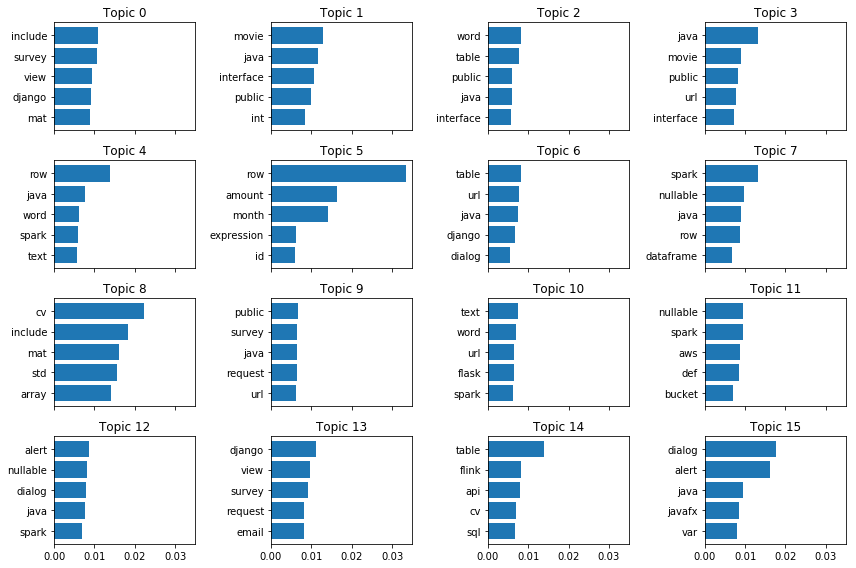

In [142]:
rows = 4
cols = 4
fig, axs = plt.subplots(nrows=rows, ncols=cols, sharex=True, figsize=(12, 8))

for topic_id, word_props in topics:
    row = topic_id // cols
    col = topic_id - (row * cols)
    
    ax = axs[row, col]
    words, probs = zip(*word_props)
    ax.barh(words, probs)
    ax.invert_yaxis()
    ax.set_title('Topic {}'.format(topic_id))

plt.tight_layout()
plt.show()

Ok at this point I've built a model that has identified 12 different topics and I've honed in on the words that co-occur within these topics. From this I can formulate some common categories which make sense given the content of the articles I fed into the model. For example in topic 8 that is mostly focussed around C++ and OpenCV while topic 15 appears to be revolving around desktop development with the Java language.

The next logical thing I'd like to do is feed my model a specific document's (aka article's) bag-of-words and take a look at the topics that the model has identified for it. As my first example I use the document bag-of-words for the article "Example Driven High Level Overview of Spark with Python" then feed that to my trained LDA model to see what topics are predicted to be associated with that article.

In [143]:
spark_bow = corpus[9]

spark_topics = lda[spark_bow]

spark_topics

[(7, 0.8079347), (11, 0.19156204)]

As you can see it predicts with about 80% probability that topic 7 composed of the words ['spark', 'nullable', 'java', 'row', 'dataframe'] are associated with that article.  Semantically this makes pretty good sense. The model also predicted that topic 11 which contains words ['nullable', 'spark', 'aws', 'def', 'bucket'] has about a 20% probability of belonging to that article.

I'll now do the same with a fairly different article titled "How to Construct an OpenCV Mat Object from C++ Arrays and Vectors".

In [144]:
opencv_bow = corpus[1]

opencv_topics = lda[opencv_bow]

opencv_topics

[(8, 0.9985553)]

For the OpenCV article the model predicted that topic 8 with words ['cv', 'include', 'mat', 'std', 'array'] mostly closely align with that specific article at a probability of over 99%.

# Conclusion

In this article I introduced and demonstrated Topic Modeling which is a meaningful aspect of NLP . Topic Modeling's general purpose was discussed and demonstrated leaning on a few techniques that can be used to perform topic modeling and identification on a collection of articles.

As always, I thank you for reading and please feel free to ask questions or critique in the comments section below.